In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from statsmodels.stats.outliers_influence import variance_inflation_factor   

In [2]:
minesota_list=["USC00210018.dly", "USC00210075.dly", #list of stations to use in this case all minnesota stations
"USC00210252.dly",
"USC00210515.dly",
"USC00211465.dly",
"USC00211630.dly",
"USC00212142.dly",
"USC00212645.dly",
"USC00212698.dly",
"USC00212737.dly",
"USC00212916.dly",
"USC00213290.dly",
"USC00213303.dly",
"USC00214106.dly",
"USC00214652.dly",
"USC00215175.dly",
"USC00215400.dly",
"USC00215563.dly",
"USC00215615.dly",
"USC00215638.dly",
"USC00215887.dly",
"USC00216152.dly",
"USC00216547.dly",
"USC00216565.dly",
"USC00217087.dly",
"USC00217405.dly",
"USC00217460.dly",
"USC00218419.dly",
"USC00218618.dly",
"USC00219046.dly",
"USC00219249.dly",
"USW00014922.dly",
"USW00094967.dly"]

station_tmax_dict = {}
station_prcp_dict = {}
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

for stationfilename in minesota_list:#for loop to go through all the file names
    key_tmax = stationfilename + "TMAX" #way of creating variable keys for the dictionary 
    key_prcp = stationfilename + "PRCP"
    tmax_arr = [] #list of lists every list inside is a row
    prcp_arr = [] 
    station = open("weatherdata/ghcnd_hcn/{}".format(stationfilename),"r") #open the file based on where it is in father loop
    for line in station: #loop to read every line and append the actual data
        if line[17:21] == "TMAX" or line[17:21] == "PRCP":
            vals=[]
            instancer = 0
            ID = line[0:11]
            year = line[11:15]
            month = line[15:17]
            element = line[17:21]
            vals=[ID,int(year),int(month),element]
            for num in range(0,31):
                if line[22+instancer:26+instancer] != "9999":
                    if line[17:21] == "TMAX":
                        z = ((float(line[22+instancer:26+instancer])/10) * (9/5) +32) #add the data to the list of lists
                        vals.append(round(z,1)) #also convert to farenheight
                        instancer+=8
                    if line[17:21] == "PRCP": #dont convert PRCP values to farenheight
                        vals.append(float(line[22+instancer:26+instancer])/10)
                        instancer+=8
                else:
                    vals.append(float(line[22+instancer:26+instancer])) #if it is 9999 just append 9999
                    instancer+=8
        if line[17:21] == "TMAX": #choose which dictonary to actual append results to
            tmax_arr.append(vals)
        if line[17:21] == "PRCP":
            prcp_arr.append(vals)
    value_tmax = pd.DataFrame(tmax_arr) #convert them to dataframes before makingit value in dictionary
    value_prcp = pd.DataFrame(prcp_arr)
    station_tmax_dict[key_tmax] = value_tmax #turn the key and value into an actual dictionary entry
    station_prcp_dict[key_prcp] = value_prcp



In [3]:
true_df_dict = {}
df_comp = []
counter = 0
for keytmax, keyprcp in zip(list(station_tmax_dict.keys()), list(station_prcp_dict.keys())): #for every actual DF in the dict
    df_tmax = station_tmax_dict[keytmax]
    df_prcp = station_prcp_dict[keyprcp]
    row1_arr = []
    actual_id = minesota_list[counter]
    for yearnum in range(1918, df_tmax[1].max()): #hardcode 1918 instead of df_tmax[1].min()
        tmax_temp_df = df_tmax[df_tmax[1]==yearnum] #cycle through year 1918->present in every indivudal df
        prcp_temp_df = df_prcp[df_prcp[1]==yearnum]
        if len(tmax_temp_df)==12: #only take values if there is data for every month of the year
            row1_arr_df = [actual_id,yearnum] #first data points in a row, the row temp list
            
            tmax_row=tmax_temp_df.iloc[:,4:] #take the data points for the days not for stationid, ele, etc...
            prcp_row=prcp_temp_df.iloc[:,4:]
            truefalse_tmax = (tmax_row>=90) & (tmax_row<1000) #count the days that are above 90
            truefalse_prcp = (prcp_row>0) & (prcp_row<9999) #record the prcp if its above 0
            
            year_total_days90 = np.sum(np.sum(truefalse_tmax)) #sum how many days are above 90
            year_total_prcp= np.sum(np.sum(prcp_row[truefalse_prcp])) #sum the percep column 
            
            row1_arr_df.append(year_total_days90) #append this to the temp list that stands for each row
            row1_arr_df.append(year_total_prcp)
            
            row1_arr.append(row1_arr_df) #append this to the list of lists for the df
            df_comp.append(row1_arr_df) #major df area where all the station values are kept
            
    true_df_dict[actual_id] = pd.DataFrame(row1_arr) #create a dictionary incase I want to come back later and get more granular
    counter +=1

In [4]:
df3 = pd.DataFrame(df_comp) #make a df that has all the info at every year
df3 = df3.sort_values(1) # sort by the year
df3 = df3.reset_index()# reset the index because the sort has messed up the index
df3.drop('index',axis=1,inplace=True) #drop the index column as reseting the index has moved the old index into a new col
df3.columns= ["station_id","year","daysabove90","total_precip"] #rename the columns
df3.drop('station_id',axis=1,inplace=True) #drop the station ids as they are irrelevant now

In [5]:
df2 = round(df3.groupby(['year']).mean()) #new dataframe that averages all the values that have equal years
df2.reset_index(inplace=True) #reset the index again as the group by has messed it up again

In [6]:
co2 = open("co2data.txt","r")
co2df = []
for line in co2: #read the non-noaa co2data and append to a list
    yearco2 = int(line[0:4])
    co2val= float(line[21:26])
    co2df.append([yearco2,co2val]) #append to a list of lists that will become a Dataframe
co2noaa = open("co2noaadata.txt","r")
co2dfnoaa=[]
for line in co2noaa: #read the noaa co2data and append to a list
    yearco2 = int(line[0:4])
    co2val= float(line[26:32])
    co2dfnoaa.append([yearco2,co2val]) #append to a list of lists that will become a Dataframe
co2df= pd.DataFrame(co2df)# convert both lists to a dataframe
co2dfnoaa=pd.DataFrame(co2dfnoaa)
co2dfnoaa = round(co2dfnoaa.groupby([0]).mean(),2) #since noaa data went monthly group by the year then take the average value

co2dfnoaa.reset_index(inplace=True) #reset the group-by index 
co2dfnoaa.columns=['year','avgco2'] #rename the columns
co2df.columns=['year','avgco2']
frames = [co2df, co2dfnoaa] #put both dataframes into a listfor the concat function

maindf = pd.concat(frames) #create a df that is a full list from 1918 to 2018 of avg co2 values for each year
maindf.reset_index(inplace=True)#reset index
maindf.drop('index',axis=1,inplace=True)#drop new index col
df = df2.merge(maindf, on='year') #merge the co2 data with the precip and tmax days we now have our working df
df.replace(df['avgco2'][66], 344.45,inplace=True) #replace 1984 with the average of 11 months as one measurment was missing

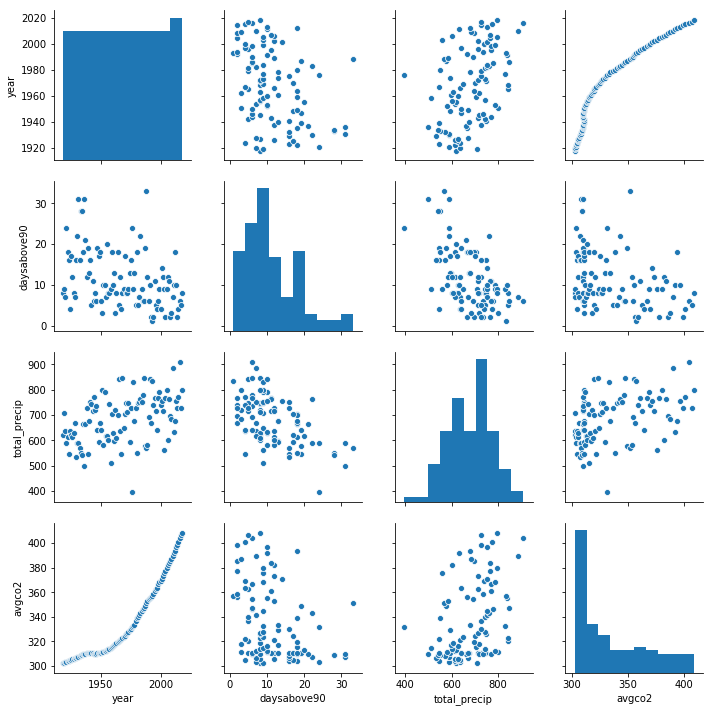

In [21]:
sns_plot = sns.pairplot(df)

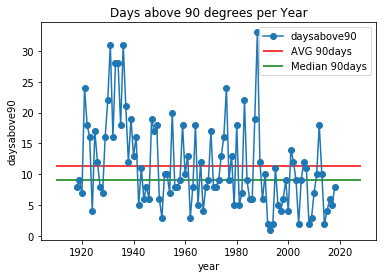

In [8]:
np.mean(df['daysabove90'])
plt.plot(df['year'],df['daysabove90'],'-o')
plt.hlines(11.3168,xmin=1910,xmax=2028,colors='r',label='AVG 90days')
plt.hlines(9,xmin=1910,xmax=2028, colors='g',label = 'Median 90days')
plt.ylabel('daysabove90')
plt.xlabel('year')
plt.title('Days above 90 degrees per Year')
plt.legend()


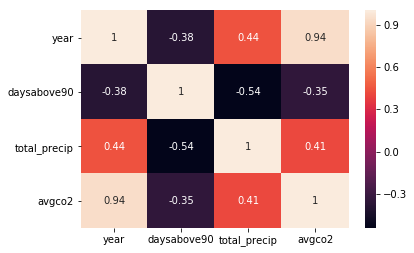

In [9]:
sns_plot2=sns.heatmap(df.corr(),annot=True)

In [10]:
vif = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif

[265.0760594003911, 5.154538218062721, 82.11377868858722, 194.31840401673068]

In [11]:
y = df['daysabove90'].values
x = df[['avgco2','total_precip','year']].values
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25,random_state=1)


kf = KFold(n_splits=10,shuffle=True,random_state=1)
predictlist= []
truelist = []
r2lst=[]
for train_index, test_index in kf.split(X_train):
    X_train_1, X_test_1 = X_train[train_index], X_train[test_index]
    y_train_1, y_test_1 = y_train[train_index], y_train[test_index]
    linear = LinearRegression()
    linear.fit(X_train_1, y_train_1)
    train_predicted = linear.predict(X_train_1)
    test_predicted = linear.predict(X_test_1)
    print("MSE train", mean_squared_error(y_train_1,train_predicted))
    print("MSE test", mean_squared_error(y_test_1,test_predicted))
    print("r2",linear.score(X_train_1,y_train_1))
    print('r2-test',linear.score(X_test_1,y_test_1))
    print('coefs',linear.coef_)
    r2lst.append(linear.score(X_train_1,y_train_1))
print(np.mean(r2lst))

MSE train 28.29975329694503
MSE test 34.75743661437946
r2 0.4384383811035787
r2-test 0.3115209089073707
coefs [-0.00155158 -0.03752239 -0.05200543]
MSE train 30.126041645687653
MSE test 20.172611007700056
r2 0.4174887967458137
r2-test 0.28434195981551913
coefs [ 0.0213682  -0.03606768 -0.07877625]
MSE train 27.41298432272549
MSE test 42.26660893193088
r2 0.4234753210427241
r2-test 0.40140230766904705
coefs [-0.00655903 -0.03324463 -0.05175779]
MSE train 29.119309842137852
MSE test 29.55789310109306
r2 0.39677436647950687
r2-test 0.4595128118657269
coefs [-0.01620612 -0.0315223  -0.04806119]
MSE train 30.230158019207327
MSE test 19.851252004260527
r2 0.4520629755544989
r2-test -0.4773024747356671
coefs [-0.01740274 -0.03841254 -0.05031366]
MSE train 29.984947316688064
MSE test 18.87617306373276
r2 0.4461604975858594
r2-test -0.05105963650330159
coefs [ 0.00672575 -0.03543965 -0.07118932]
MSE train 27.35848857282424
MSE test 45.21915744569312
r2 0.43760268889152987
r2-test 0.245834338039

In [12]:
y = df['daysabove90'].values
x = df[['year']].values
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25,random_state=1)


kf = KFold(n_splits=10,shuffle=True,random_state=1)
predictlist= []
truelist = []
r2lst=[]
for train_index, test_index in kf.split(X_train):
    X_train_1, X_test_1 = X_train[train_index], X_train[test_index]
    y_train_1, y_test_1 = y_train[train_index], y_train[test_index]
    linear = LinearRegression()
    linear.fit(X_train_1, y_train_1)
    train_predicted = linear.predict(X_train_1)
    test_predicted = linear.predict(X_test_1)
    print("MSE train", mean_squared_error(y_train_1,train_predicted))
    print("MSE test", mean_squared_error(y_test_1,test_predicted))
    print("r2",linear.score(X_train_1,y_train_1))
    print('r2-test',linear.score(X_test_1,y_test_1))
    print('coefs',linear.coef_)
    r2lst.append(linear.score(X_train_1,y_train_1))
print(np.mean(r2lst))

MSE train 38.95651134792514
MSE test 33.3070779056648
r2 0.22697271069641367
r2-test 0.3402497722183389
coefs [-0.11472452]
MSE train 39.54477198512851
MSE test 29.65991878778754
r2 0.23537008338541565
r2-test -0.05223658670643161
coefs [-0.11625118]
MSE train 35.501700789202495
MSE test 62.27537261056876
r2 0.25336087421300946
r2-test 0.11802968641814549
coefs [-0.11787024]
MSE train 36.62688854730827
MSE test 54.12992812958224
r2 0.24124994144392697
r2-test 0.01019559991621044
coefs [-0.11459953]
MSE train 41.81043336089255
MSE test 9.39521091336434
r2 0.24216458174024813
r2-test 0.30082151342404917
coefs [-0.12125585]
MSE train 40.18391815131017
MSE test 21.082074620984674
r2 0.2577795452191455
r2-test -0.17388824594119212
coefs [-0.12339019]
MSE train 37.72335593902112
MSE test 44.95651141544221
r2 0.2245363303012642
r2-test 0.2502147517506236
coefs [-0.11287081]
MSE train 40.061150910330404
MSE test 21.830632979413554
r2 0.250272131255594
r2-test -0.3438454974764624
coefs [-0.1214

In [13]:
y = df['daysabove90'].values
x = df[['total_precip']].values
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25,random_state=1)


kf = KFold(n_splits=10,shuffle=True,random_state=1)
predictlist= []
truelist = []
r2lst=[]
for train_index, test_index in kf.split(X_train):
    X_train_1, X_test_1 = X_train[train_index], X_train[test_index]
    y_train_1, y_test_1 = y_train[train_index], y_train[test_index]
    linear = LinearRegression()
    linear.fit(X_train_1, y_train_1)
    train_predicted = linear.predict(X_train_1)
    test_predicted = linear.predict(X_test_1)
    print("MSE train", mean_squared_error(y_train_1,train_predicted))
    print("MSE test", mean_squared_error(y_test_1,test_predicted))
    print("r2",linear.score(X_train_1,y_train_1))
    print('r2-test',linear.score(X_test_1,y_test_1))
    print('coefs',linear.coef_)
    r2lst.append(linear.score(X_train_1,y_train_1))
print(np.mean(r2lst))

MSE train 30.197679767321986
MSE test 42.9004706675325
r2 0.40077718137268525
r2-test 0.15022280324293402
coefs [-0.04520512]
MSE train 32.57582908681244
MSE test 23.082552966415616
r2 0.3701201896506674
r2-test 0.18110676837549922
coefs [-0.04454843]
MSE train 29.512003713645864
MSE test 48.54130642521582
r2 0.37933067534385156
r2-test 0.3125373730440778
coefs [-0.04227931]
MSE train 31.884770119252025
MSE test 30.438391559046448
r2 0.3394860400500132
r2-test 0.4434122686345792
coefs [-0.04089549]
MSE train 33.51217122046397
MSE test 15.523345291129846
r2 0.39257481321856913
r2-test -0.15522569608408165
coefs [-0.04739481]
MSE train 32.936918477695066
MSE test 17.389273242369566
r2 0.3916358648864683
r2-test 0.03173364900442188
coefs [-0.04462048]
MSE train 29.900060101165863
MSE test 47.37182691707053
r2 0.3853566377354364
r2-test 0.20993209021904158
coefs [-0.04321617]
MSE train 32.088502493922576
MSE test 26.93975666294221
r2 0.39947694863243477
r2-test -0.6583518548796083
coefs [-

In [14]:
y = df['daysabove90'].values
x = df[['avgco2']].values
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25,random_state=1)


kf = KFold(n_splits=10,shuffle=True,random_state=1)
predictlist= []
truelist = []
r2lst=[]
for train_index, test_index in kf.split(X_train):
    X_train_1, X_test_1 = X_train[train_index], X_train[test_index]
    y_train_1, y_test_1 = y_train[train_index], y_train[test_index]
    linear = LinearRegression()
    linear.fit(X_train_1, y_train_1)
    train_predicted = linear.predict(X_train_1)
    test_predicted = linear.predict(X_test_1)
    print("MSE train", mean_squared_error(y_train_1,train_predicted))
    print("MSE test", mean_squared_error(y_test_1,test_predicted))
    print("r2",linear.score(X_train_1,y_train_1))
    print('r2-test',linear.score(X_test_1,y_test_1))
    print('coefs',linear.coef_)
    r2lst.append(linear.score(X_train_1,y_train_1))
print(np.mean(r2lst))

MSE train 39.844843923432315
MSE test 34.34851455809684
r2 0.20934522560896984
r2-test 0.31962088154806634
coefs [-0.11254866]
MSE train 40.40887838718337
MSE test 31.213446622085364
r2 0.21866189231535937
r2-test -0.1073506562158888
coefs [-0.11213739]
MSE train 36.14177761921282
MSE test 65.68181615893259
r2 0.2398993669000763
r2-test 0.0697861840735371
coefs [-0.11278756]
MSE train 37.30150386884505
MSE test 57.19287470815117
r2 0.22727484186489177
r2-test -0.04581256609190709
coefs [-0.10858063]
MSE train 42.651114029808134
MSE test 11.037746155117883
r2 0.2269268160646013
r2-test 0.17858633264239013
coefs [-0.1182176]
MSE train 41.36291453161547
MSE test 19.311562604178757
r2 0.23600279298009952
r2-test -0.07530291773268072
coefs [-0.11654661]
MSE train 37.792877246215774
MSE test 54.17474708764427
r2 0.22310720909352832
r2-test 0.09647290425644361
coefs [-0.1099345]
MSE train 41.04543094642068
MSE test 22.286024979060777
r2 0.23185173750910937
r2-test -0.37187842207786187
coefs [

In [22]:
y = df['daysabove90'].values
x = df[['total_precip']].values
x = sm.add_constant(x)
mod = sm.OLS(y,x)
res = mod.fit()
mod2 = LinearRegression().fit(x,y)
predict = mod2.predict(x)
print(mod2.score(x,y))
print(mod2.coef_)
print(res.summary())

0.2929259709343035
[ 0.         -0.04011683]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     41.01
Date:                Thu, 14 Feb 2019   Prob (F-statistic):           5.11e-09
Time:                        19:57:52   Log-Likelihood:                -322.68
No. Observations:                 101   AIC:                             649.4
Df Residuals:                      99   BIC:                             654.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const  

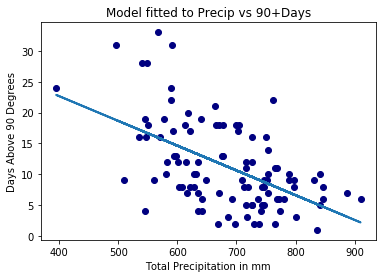

In [20]:
plt.scatter(df['total_precip'],df['daysabove90'],color='navy')
plt.plot(df['total_precip'],predict,linewidth=2)
plt.ylabel('Days Above 90 Degrees')
plt.xlabel('Total Precipitation in mm')
plt.title('Model fitted to Precip vs 90+Days')